# Author : Kartik B Bhargav

**Reading material**
* [1] Mikolov, Tomas, et al. "[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)" Advances in neural information processing systems. 2013. 

# Keras implementation

### Word embeddings
Build word embeddings with a Keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training. Use a window size of 2 to train the embeddings (`window_size` in the jupyter notebook). 

1. Build word embeddings of length 50, 150 and 300 using the Skipgram model
2. Build word embeddings of length 50, 150 and 300 using CBOW model
3. Analyze the different word embeddings:
    - Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in the paper. Do not use existing libraries for this task such as Gensim. 
Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. $e_{x}$ denotes the embedding of word $x$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.


4. Discuss:
  - Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?



### Import libraries

In [1]:
import numpy as np
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence

# other helpful libraries
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
import pandas as pd

Using TensorFlow backend.


In [2]:
print(tf.__version__) #  check what version of TF is imported

2.1.0


### Import file

If you use Google Colab, you need to mount your Google Drive to the notebook when you want to use files that are located in your Google Drive. Paste the authorization code, from the new tab page that opens automatically when running the cell, in the cell below.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Navigate to the folder in which `alice.txt` is located. Make sure to start path with '/content/drive/My Drive/' if you want to load the file from your Google Drive.

In [4]:
# cd '/content/drive/My Drive/Colab Notebooks/DL course/'

In [5]:
file_name = 'alice.txt'
corpus = open(file_name).readlines()

### Data preprocessing

See Practical 3.1 for an explanation of the preprocessing steps done below.

In [6]:
# Removes sentences with fewer than 3 words
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)

# convert text to sequence of integer values
corpus = tokenizer.texts_to_sequences(corpus)
n_samples = sum(len(s) for s in corpus) # total number of words in the corpus
V = len(tokenizer.word_index) + 1 # total number of unique words in the corpus

In [7]:
n_samples, V

(27165, 2557)

In [8]:
# example of how word to integer mapping looks like in the tokenizer
print(list((tokenizer.word_index.items()))[:5])

[('the', 1), ('and', 2), ('to', 3), ('a', 4), ('it', 5)]


In [9]:
# parameters
window_size = 2
window_size_corpus = 4

In [10]:
corpus[:1]

[[305, 7, 38, 1, 92, 595]]

## Task 1.1 - Skipgram
Build word embeddings of length 50, 150 and 300 using the Skipgram model.

In [11]:
#generate data for Skipgram
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # Add the input word
                    #in_words.append(word)
                    all_in.append(word)
                    # Add one-hot of the context words
                    all_out.append(to_categorical(words[i], V))
                                      
    return (np.array(all_in),np.array(all_out))

In [12]:
# create training data
x, y = generate_data_skipgram(corpus, window_size, V)

In [13]:
x.shape, y.shape

((94556,), (94556, 2557))

In [14]:
# create skipgram architecture
def generate_skipgram_model(input_dim, output_dim, embeddings_initializer, input_length, kernel_initializer):
    skipgram = Sequential()
    skipgram.add(Embedding(input_dim=input_dim, output_dim=output_dim,
                           embeddings_initializer=embeddings_initializer, input_length=input_length))
    skipgram.add(Reshape((output_dim, )))
    skipgram.add(Dense(V, kernel_initializer=kernel_initializer, activation='softmax'))
    skipgram.compile(loss='categorical_crossentropy', 
                     optimizer='adadelta',
                     metrics=['accuracy'])
    return skipgram

In [15]:
# save embeddings for vectors of length 50, 150 and 300 using skipgram model
def save_embeddings(model, file_name):
    model_weights = model.get_weights()
    embedding = model_weights[0]
    np.savetxt(file_name, embedding)

In [16]:
dims = [50, 150, 300]
skipgram_models = [generate_skipgram_model(V, dim, 'glorot_uniform', 1, 'glorot_uniform') for dim in dims]

In [17]:
skipgram_models[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 50)             127850    
_________________________________________________________________
reshape (Reshape)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 2557)              130407    
Total params: 258,257
Trainable params: 258,257
Non-trainable params: 0
_________________________________________________________________


In [18]:
skipgram_models[1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 150)            383550    
_________________________________________________________________
reshape_1 (Reshape)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2557)              386107    
Total params: 769,657
Trainable params: 769,657
Non-trainable params: 0
_________________________________________________________________


In [19]:
skipgram_models[2].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 300)            767100    
_________________________________________________________________
reshape_2 (Reshape)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2557)              769657    
Total params: 1,536,757
Trainable params: 1,536,757
Non-trainable params: 0
_________________________________________________________________


<b>HINT</b>: To increase training speed of your model, you can use the free available GPU power in Google Colab. Go to `Edit` --> `Notebook Settings` --> select `GPU` under `hardware accelerator`.

In [20]:
# train skipgram model for the dimensions [50, 150, 300]
skipgram_models[0].fit(x, y, batch_size=32, epochs=10) # dim = 50
skipgram_models[1].fit(x, y, batch_size=32, epochs=10) # dim = 150
skipgram_models[2].fit(x, y, batch_size=32, epochs=10) # dim = 300

Train on 94556 samples
Epoch 1/10
94556/94556 [==============================] - 6s 63us/sample - loss: 7.8459 - accuracy: 5.9224e-04
Epoch 2/10
94556/94556 [==============================] - 6s 59us/sample - loss: 7.8445 - accuracy: 0.0041
Epoch 3/10
94556/94556 [==============================] - 5s 52us/sample - loss: 7.8431 - accuracy: 0.0095
Epoch 4/10
94556/94556 [==============================] - 5s 53us/sample - loss: 7.8418 - accuracy: 0.0182
Epoch 5/10
94556/94556 [==============================] - 5s 52us/sample - loss: 7.8405 - accuracy: 0.0279
Epoch 6/10
94556/94556 [==============================] - 5s 53us/sample - loss: 7.8391 - accuracy: 0.0378
Epoch 7/10
94556/94556 [==============================] - 5s 54us/sample - loss: 7.8377 - accuracy: 0.0440
Epoch 8/10
94556/94556 [==============================] - 5s 53us/sample - loss: 7.8364 - accuracy: 0.0496
Epoch 9/10
94556/94556 [==============================] - 5s 53us/sample - loss: 7.8350 - accuracy: 0.0520
Epoch 10/1

In [21]:
save_embeddings(skipgram_models[0], 'weights_skipgram_50.txt') # dim = 50
save_embeddings(skipgram_models[1], 'weights_skipgram_150.txt') # dim = 150
save_embeddings(skipgram_models[2], 'weights_skipgram_300.txt') # dim =300

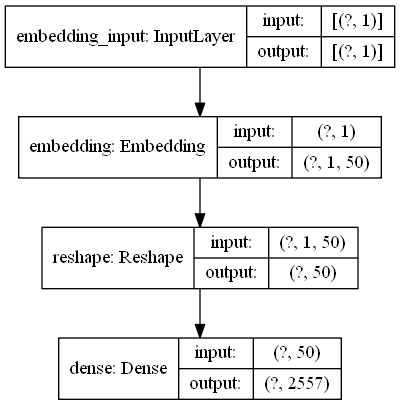

In [22]:
plot_model(skipgram_models[0], show_shapes = True, show_layer_names=True)

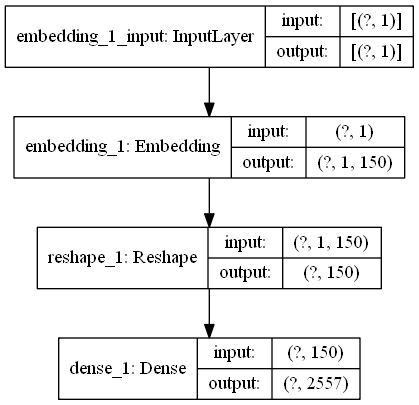

In [23]:
plot_model(skipgram_models[1], show_shapes = True, show_layer_names=True)

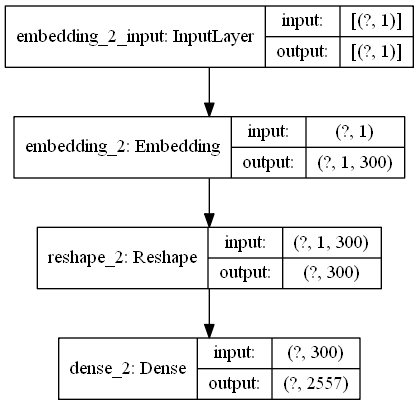

In [24]:
plot_model(skipgram_models[2], show_shapes = True, show_layer_names=True)

## Task 1.2 - CBOW

Build word embeddings of length 50, 150 and 300 using CBOW model.

In [25]:
# prepare data for CBOW

# create training data

# create CBOW architecture

# train CBOW model

# save embeddings for vectors of length 50, 150 and 300 using CBOW model

In [26]:
def generate_data_cbow(corpus, window_size, V):
    maxlen = window_size*2
    input_list = []
    output_list = []
    
    for line in corpus:
        sentence_length = len(line)
      
        for index, word in enumerate(line):  #for each word in the line, we create a little neighborhood [left,right]
            left = index - window_size
            right = index + window_size + 1
      
            input_words = []   #neighbor words of wt, used as input to predict wt       
      
            for i in range(left, right):
                if 0 <= i < sentence_length and i != index:
                    # append the input word 
                    input_words.append(line[i])

            input_list.append(input_words)
            output_list.append(to_categorical(word,V))
      
    input_list = sequence.pad_sequences(input_list, maxlen=maxlen)
                                      
    return (np.array(input_list),np.array(output_list))

In [27]:
x_cbow, y_cbow = generate_data_cbow(corpus, window_size, V)

In [28]:
x_cbow.shape, y_cbow.shape

((27165, 4), (27165, 2557))

In [29]:
def generate_cbow_model(input_dim, output_dim, embeddings_initializer, input_length, kernel_initializer):
    cbow = Sequential()
    cbow.add(Embedding(input_dim=input_dim, output_dim=output_dim, 
                       embeddings_initializer='glorot_uniform', 
                       input_length=window_size*2))

    cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(output_dim,)))
    cbow.add(Dense(V, kernel_initializer=kernel_initializer, activation='softmax'))
    cbow.compile(loss='categorical_crossentropy', 
                 optimizer='adadelta', 
                 metrics=['accuracy'])
    return cbow

In [30]:
cbow_models = [generate_cbow_model(V, dim, 'glorot_uniform', window_size * 2, 'glorot_uniform') for dim in dims]

In [31]:
cbow_models[0].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 50)             127850    
_________________________________________________________________
lambda (Lambda)              (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2557)              130407    
Total params: 258,257
Trainable params: 258,257
Non-trainable params: 0
_________________________________________________________________


In [32]:
cbow_models[1].summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 4, 150)            383550    
_________________________________________________________________
lambda_1 (Lambda)            (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2557)              386107    
Total params: 769,657
Trainable params: 769,657
Non-trainable params: 0
_________________________________________________________________


In [33]:
cbow_models[2].summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 4, 300)            767100    
_________________________________________________________________
lambda_2 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2557)              769657    
Total params: 1,536,757
Trainable params: 1,536,757
Non-trainable params: 0
_________________________________________________________________


In [34]:
# train cbow model for dimensions [50, 150, 300]
cbow_models[0].fit(x_cbow, y_cbow, batch_size=64, epochs=10) # dim = 50
cbow_models[1].fit(x_cbow, y_cbow, batch_size=64, epochs=10) # dim = 150
cbow_models[2].fit(x_cbow, y_cbow, batch_size=64, epochs=10) # dim = 300

Train on 27165 samples
Epoch 1/10
27165/27165 [==============================] - 1s 45us/sample - loss: 7.8464 - accuracy: 1.8406e-04
Epoch 2/10
27165/27165 [==============================] - 1s 37us/sample - loss: 7.8461 - accuracy: 5.1537e-04
Epoch 3/10
27165/27165 [==============================] - 1s 40us/sample - loss: 7.8459 - accuracy: 5.8899e-04
Epoch 4/10
27165/27165 [==============================] - 1s 38us/sample - loss: 7.8457 - accuracy: 8.4668e-04
Epoch 5/10
27165/27165 [==============================] - 1s 37us/sample - loss: 7.8454 - accuracy: 0.0013
Epoch 6/10
27165/27165 [==============================] - 1s 37us/sample - loss: 7.8452 - accuracy: 0.0023
Epoch 7/10
27165/27165 [==============================] - 1s 35us/sample - loss: 7.8449 - accuracy: 0.0039
Epoch 8/10
27165/27165 [==============================] - 1s 35us/sample - loss: 7.8447 - accuracy: 0.0067
Epoch 9/10
27165/27165 [==============================] - 1s 34us/sample - loss: 7.8445 - accuracy: 0.009

In [35]:
save_embeddings(cbow_models[0], 'weights_cbow_50.txt') # dim = 50
save_embeddings(cbow_models[1], 'weights_cbow_150.txt') # dim = 150
save_embeddings(cbow_models[2], 'weights_cbow_300.txt') # dim =300

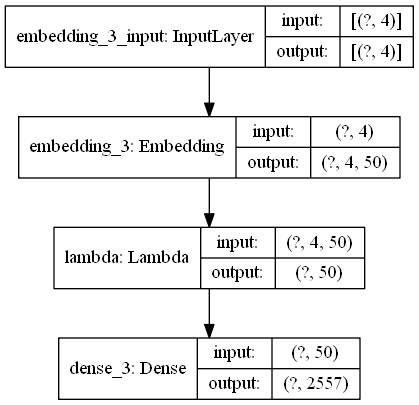

In [36]:
plot_model(cbow_models[0], show_shapes = True, show_layer_names=True)

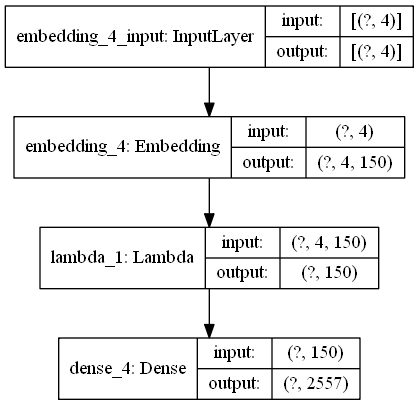

In [37]:
plot_model(cbow_models[1], show_shapes = True, show_layer_names=True)

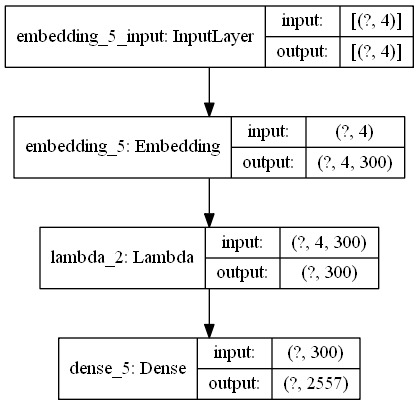

In [38]:
plot_model(cbow_models[2], show_shapes = True, show_layer_names=True)

In [39]:
cbow_models[0].weights[0].shape

TensorShape([2557, 50])

## Task 1.3 - Analogy function

Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in [1]. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. 

In a perfect scenario, we would like that this analogy ( $e_{king} - e_{queen} + e_{woman}$) results in the embedding of the word "man". However, it does not always result in exactly the same word embedding. The result of the formula is called the expected or the predicted word embedding. In this context, "man" is called the true or the actual word $t$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.  

You have to answer an analogy function using each embedding for both CBOW and Skipgram model. This means that for each analogy we have 6 outputs. Show the true word (with distance similarity value between predicted embedding and true word embedding, i.e. `sim1`) , the predicted word (with distance similarity value between predicted embedding and the embedding of the word in the vocabulary that is closest to this predicted embedding, i.e. `sim2`) and a boolean answer whether the predicted word **exactly** equals the true word. 

<b>HINT</b>: to visualize the results of the analogy tasks , you can print them in a table. An example is given below.


| Analogy task | True word (sim1)  | Predicted word (sim2) | Embedding | Correct?|
|------|------|------|------|------|
|  queen is to king as woman is to ?	 | man (sim1) | predictd_word(sim2) | SG_50 | True / False|

* Give at least 5 different  examples of analogies.
* Compare the performance on the analogy s between the word embeddings and briefly discuss your results.

In [40]:
embedding = skipgram_models[0].get_weights()[0]

In [41]:
# Embed a word by getting the one hot encoding and taking the dot product of this vector with the embedding matrix
# 'word' = string type
def embed(word, embedding=embedding, vocab_size = V, tokenizer=tokenizer):
    # get the index of the word from the tokenizer, i.e. convert the string to it's corresponding integer in the vocabulary
    int_word = tokenizer.texts_to_sequences([word])[0]
    # get the one-hot encoding of the word
    bin_word = to_categorical(int_word, V)
    return np.dot(bin_word, embedding)

In [42]:
def get_nearest_word(embed_word1, embed_word2, embed_word3, predicted_embedding, embedding):
    
    
    index_of_excluded_words = []
    words_to_exclude = [predicted_embedding, embed_word1, embed_word2, embed_word3]
    
    
    for i in range(V):
        for j in words_to_exclude:
            if np.array_equal(j, embedding[[i]]):
                index_of_excluded_words.append(i)
    
    largest_dist = 0
    
    index = 0

    index_of_included_words = [x for x in range(V) if x not in index_of_excluded_words]

    
    for i in index_of_included_words:  
        temp_word = embedding[[i]]
        
        dist = cosine_similarity(predicted_embedding, temp_word)
        
        if dist > largest_dist:
            largest_dist = dist
            index = i
  
    temp_list = list((tokenizer.word_index.items()))

    closest_word = [item[0] for item in temp_list if item[1] == index]
    
    
    return (largest_dist[0][0], closest_word[0])

In [43]:
def get_analogy(word1, word2, word3, true_word):

    analogy = word2 + ' is to ' + word1 + ' as ' + word3 + ' is to _____'
    
    result_df = pd.DataFrame(columns=['Analogy task', 
                                      'True word (sim1)', 
                                      'Predicted word (sim2)', 
                                      'Embedding', 
                                      'Correct?'])
    
    models = ['weights_skipgram_50',
              'weights_skipgram_150',
              'weights_skipgram_300',
              'weights_cbow_50',
              'weights_cbow_150',
              'weights_cbow_300']

    for i, model in enumerate(models):
        embedding = np.loadtxt(model + '.txt')
    
        word1_embed = embed(word1, embedding)
        word2_embed = embed(word2, embedding)
        word3_embed = embed(word3, embedding)
    
        predicted_embedding = word2_embed - word1_embed + word3_embed

        similarity1 = cosine_similarity(predicted_embedding, embed(true_word, embedding))
        similarity1 = similarity1[0][0]
        similarity1 = ' ({value})'.format(value=similarity1)
        
        pair = get_nearest_word(word1_embed, word2_embed, word3_embed, predicted_embedding, embedding)
        predicted_word = pair[1]
        
        similarity2 = pair[0]
        similarity2 = ' ({value})'.format(value=similarity2)
        
        true_word_str = true_word + similarity1
    
        predicted_word_str = predicted_word + similarity2

        result_df.loc[i] = [analogy] + [true_word_str] + [predicted_word_str] + [model] + [true_word == predicted_word]

    return result_df

In [44]:
get_analogy('king', 'queen', 'woman', 'man')

,Analogy task,True word (sim1),Predicted word (sim2),Embedding,Correct?
0,queen is to king as woman is to _____,man (0.1502882425847857),scolded (0.5019497368850239),weights_skipgram_50,False
1,queen is to king as woman is to _____,man (-0.06998455803958539),beak (0.2883205524875558),weights_skipgram_150,False
2,queen is to king as woman is to _____,man (-0.009413754678270783),agony (0.1835969199654301),weights_skipgram_300,False
3,queen is to king as woman is to _____,man (0.10175374015089679),violent (0.4983568542399161),weights_cbow_50,False
4,queen is to king as woman is to _____,man (0.07444440752385277),provoking (0.2587516137662047),weights_cbow_150,False
5,queen is to king as woman is to _____,man (-0.0641729795687589),fine (0.17827628908057103),weights_cbow_300,False


In [45]:
get_analogy('man', 'woman', 'brother', 'sister')

,Analogy task,True word (sim1),Predicted word (sim2),Embedding,Correct?
0,woman is to man as brother is to _____,sister (-0.009800222695689802),tart (0.42124074167033265),weights_skipgram_50,False
1,woman is to man as brother is to _____,sister (0.13458942895334297),stand (0.28016701553736834),weights_skipgram_150,False
2,woman is to man as brother is to _____,sister (-0.12141385124896732),m (0.19785447652227195),weights_skipgram_300,False
3,woman is to man as brother is to _____,sister (0.1311073319031238),ridiculous (0.4498671276140966),weights_cbow_50,False
4,woman is to man as brother is to _____,sister (0.10464831513179608),anxious (0.3104450471817921),weights_cbow_150,False
5,woman is to man as brother is to _____,sister (0.11807813076385815),offend (0.22805382055430148),weights_cbow_300,False


In [46]:
get_analogy('child', 'children', 'thing', 'things')

,Analogy task,True word (sim1),Predicted word (sim2),Embedding,Correct?
0,children is to child as thing is to _____,things (0.08263401919649965),flown (0.4200887289311576),weights_skipgram_50,False
1,children is to child as thing is to _____,things (0.037240739628781064),must (0.28136964178270685),weights_skipgram_150,False
2,children is to child as thing is to _____,things (-0.05565843394508958),enormous (0.19884138077104846),weights_skipgram_300,False
3,children is to child as thing is to _____,things (-0.05435773579852159),balls (0.4819835785529824),weights_cbow_50,False
4,children is to child as thing is to _____,things (0.10774548940709376),terms (0.28679352915920886),weights_cbow_150,False
5,children is to child as thing is to _____,things (-0.013169401015570861),cold (0.2365006981283153),weights_cbow_300,False


In [47]:
get_analogy('eye', 'see', 'ear', 'hear')   

,Analogy task,True word (sim1),Predicted word (sim2),Embedding,Correct?
0,see is to eye as ear is to _____,hear (0.034776785143891015),knelt (0.43992711496822734),weights_skipgram_50,False
1,see is to eye as ear is to _____,hear (0.08452480318117789),took (0.24533237629899812),weights_skipgram_150,False
2,see is to eye as ear is to _____,hear (-0.00742672793194161),doubtful (0.19595501962353762),weights_skipgram_300,False
3,see is to eye as ear is to _____,hear (-0.19536292819253487),unlocking (0.4221325611844432),weights_cbow_50,False
4,see is to eye as ear is to _____,hear (-0.19025359698665587),cauldron (0.2547776290423087),weights_cbow_150,False
5,see is to eye as ear is to _____,hear (0.0651427258521401),ears (0.21897409404157292),weights_cbow_300,False


In [48]:
get_analogy('he', 'she', 'man', 'woman')    

,Analogy task,True word (sim1),Predicted word (sim2),Embedding,Correct?
0,she is to he as man is to _____,woman (0.22383541976021648),milk (0.4534708920231655),weights_skipgram_50,False
1,she is to he as man is to _____,woman (0.036214516672151434),mistake (0.3253697134628336),weights_skipgram_150,False
2,she is to he as man is to _____,woman (0.04617959528951802),scratching (0.2155622308467392),weights_skipgram_300,False
3,she is to he as man is to _____,woman (0.12305937855005233),pie (0.46133473071913345),weights_cbow_50,False
4,she is to he as man is to _____,woman (-0.06996427856884091),roses (0.2683691782691048),weights_cbow_150,False
5,she is to he as man is to _____,woman (0.04444503612629783),ve (0.19598778035511683),weights_cbow_300,False


In [49]:
get_analogy('herself', 'himself', 'he', 'she') 

,Analogy task,True word (sim1),Predicted word (sim2),Embedding,Correct?
0,himself is to herself as he is to _____,she (0.07649189775234495),terms (0.43096624335995226),weights_skipgram_50,False
1,himself is to herself as he is to _____,she (-0.02663596637769904),flower (0.3212232653680582),weights_skipgram_150,False
2,himself is to herself as he is to _____,she (-0.025785791988800943),fig (0.1851514925362805),weights_skipgram_300,False
3,himself is to herself as he is to _____,she (-0.03470882125744389),whiskers (0.47765104806981035),weights_cbow_50,False
4,himself is to herself as he is to _____,she (0.09986424700410262),mournful (0.26632762928886855),weights_cbow_150,False
5,himself is to herself as he is to _____,she (0.004931603773171431),picture (0.22893578133986625),weights_cbow_300,False


In [50]:
get_analogy('man', 'woman', 'herself', 'himself')

,Analogy task,True word (sim1),Predicted word (sim2),Embedding,Correct?
0,woman is to man as herself is to _____,himself (-0.1711132928906235),machines (0.4900894962974936),weights_skipgram_50,False
1,woman is to man as herself is to _____,himself (-0.033894620536833855),double (0.31299035898834743),weights_skipgram_150,False
2,woman is to man as herself is to _____,himself (-0.013512785663952302),which (0.21915083395960938),weights_skipgram_300,False
3,woman is to man as herself is to _____,himself (-0.04527550481288285),voices (0.49644589952701634),weights_cbow_50,False
4,woman is to man as herself is to _____,himself (0.03241882820888016),whistle (0.31430052090247385),weights_cbow_150,False
5,woman is to man as herself is to _____,himself (0.008773330533037575),sob (0.1880851896850811),weights_cbow_300,False


## Task 1.4 - Discussion
Answer the following question:
* Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?

In Continuous Bag of Words, the word is predicted based on the context of the word. The context of words is not just limited to the previous word or the next word but depends on the window size. All the context words are embedded using the same word embedding. The Skip-gram model works in the reverse way as compared to CBOW. Hence, rather than looking for a word based on context, the Skip-gram model tries to learn the context based on the word. The goal of the skip-gram model is to find the embedding matrix. And, when the embedding matrix is trained on a large corpus then it has more probability to capture the semantic relationships between the words.

When the same number of sentences are given as input to the CBOW and Skip-gram model, the Skip-gram model arrange the data into more training samples as compared to the CBOW model. When Skipgram generates the training data, it tries to select the maximum window size L­­­­max then go through the available sentences.